## Installing PyTorch Environment

In [9]:
%pip install torch torchvision torchaudio
%pip install pandas
%pip install scikit-learn
%pip install xlrd
%pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


🔵 Training normal model (300 epochs)...
🔴 Training overfit model (1000 epochs)...


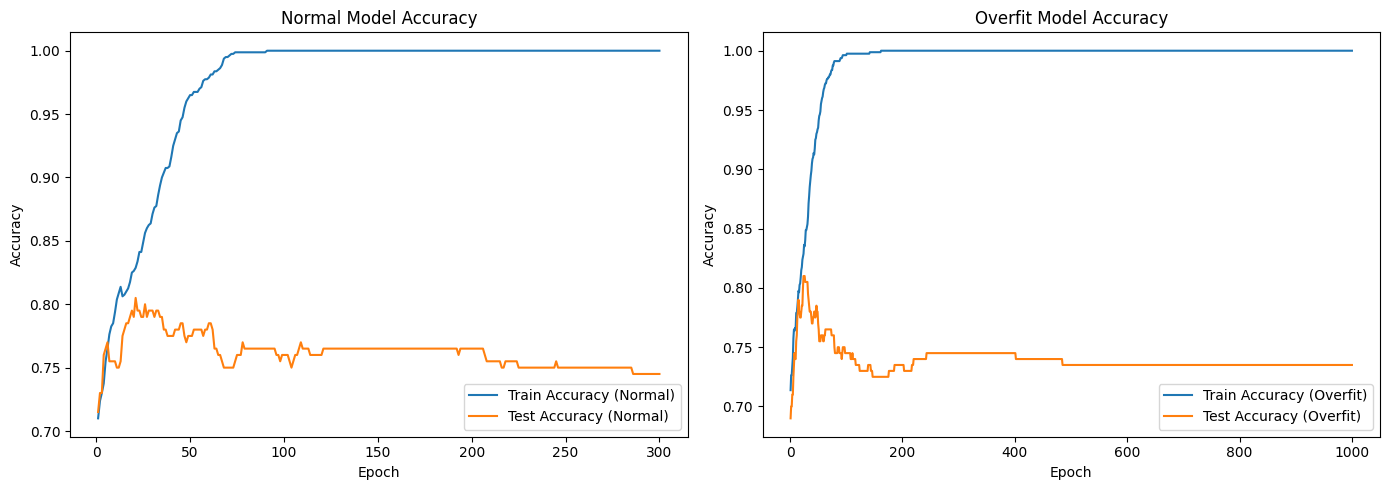

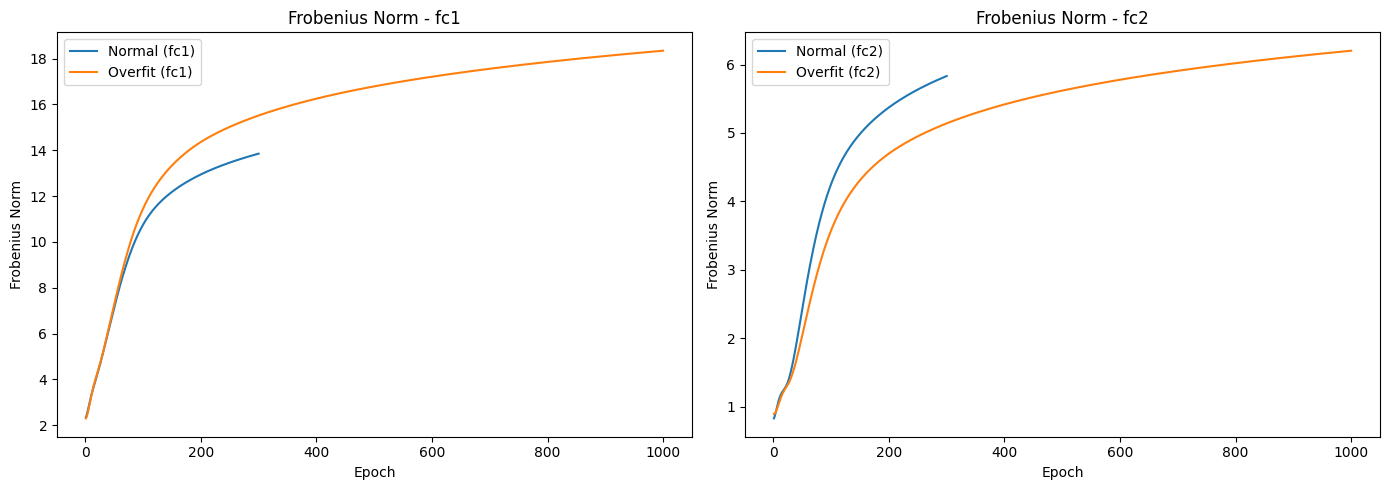

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

column_names = [
    'Status', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmount',
    'Savings', 'Employment', 'InstallmentRate', 'PersonalStatusSex',
    'OtherDebtors', 'ResidenceDuration', 'Property', 'Age', 'OtherInstallmentPlans',
    'Housing', 'ExistingCredits', 'Job', 'NumLiablePeople', 'Telephone', 'ForeignWorker',
    'Target'
]

df = pd.read_csv('german.data', sep=' ', names=column_names)
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols)
df['Target'] = df['Target'] - 1

X = df.drop(columns='Target').values
y = df['Target'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=2):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == y).sum().item()
        total = y.size(0)
    model.train()
    return correct / total

def compute_layerwise_frobenius_norm(model):
    norms = {}
    norms['fc1'] = torch.norm(model.fc1.weight.data, p='fro').item()
    norms['fc2'] = torch.norm(model.fc2.weight.data, p='fro').item()
    return norms

def train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    train_accs = []
    test_accs = []
    layerwise_norms = {'fc1': [], 'fc2': []}

    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_accs.append(compute_accuracy(model, X_train, y_train))
        test_accs.append(compute_accuracy(model, X_test, y_test))

        layer_norms = compute_layerwise_frobenius_norm(model)
        for layer in layerwise_norms:
            layerwise_norms[layer].append(layer_norms[layer])

    return model, losses, train_accs, test_accs, layerwise_norms

input_size = X_train.shape[1]

print("🔵 Training normal model (300 epochs)...")
model_normal = TwoLayerNN(input_size)
model_normal, normal_losses, normal_train_accs, normal_test_accs, normal_layer_norms = train_model(
    model_normal, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=300
)

print("🔴 Training overfit model (1000 epochs)...")
model_overfit = TwoLayerNN(input_size)
model_overfit, overfit_losses, overfit_train_accs, overfit_test_accs, overfit_layer_norms = train_model(
    model_overfit, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=1000
)

# Accuracy Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 301), normal_train_accs, label='Train Accuracy (Normal)')
plt.plot(range(1, 301), normal_test_accs, label='Test Accuracy (Normal)')
plt.title('Normal Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 1001), overfit_train_accs, label='Train Accuracy (Overfit)')
plt.plot(range(1, 1001), overfit_test_accs, label='Test Accuracy (Overfit)')
plt.title('Overfit Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Frobenius Norm Plots
plt.figure(figsize=(14, 5))
for i, layer in enumerate(['fc1', 'fc2']):
    plt.subplot(1, 2, i+1)
    plt.plot(range(1, 301), normal_layer_norms[layer], label=f'Normal ({layer})')
    plt.plot(range(1, 1001), overfit_layer_norms[layer], label=f'Overfit ({layer})')
    plt.title(f'Frobenius Norm - {layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Frobenius Norm')
    plt.legend()

plt.tight_layout()
plt.show()


Training normal model (300 epochs)...
Training overfit model (1000 epochs)...


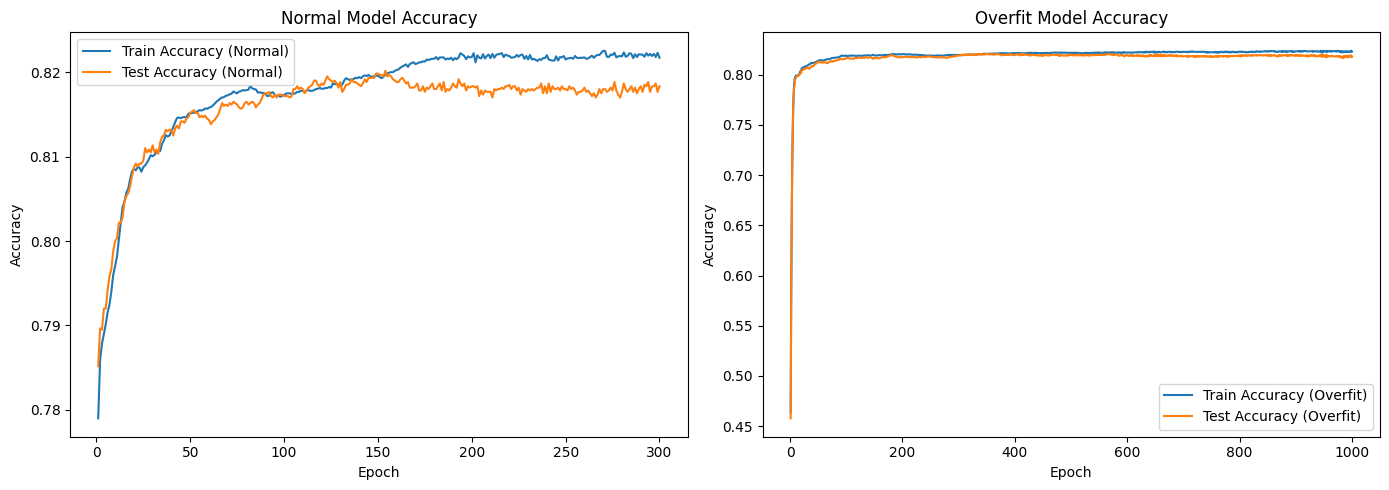

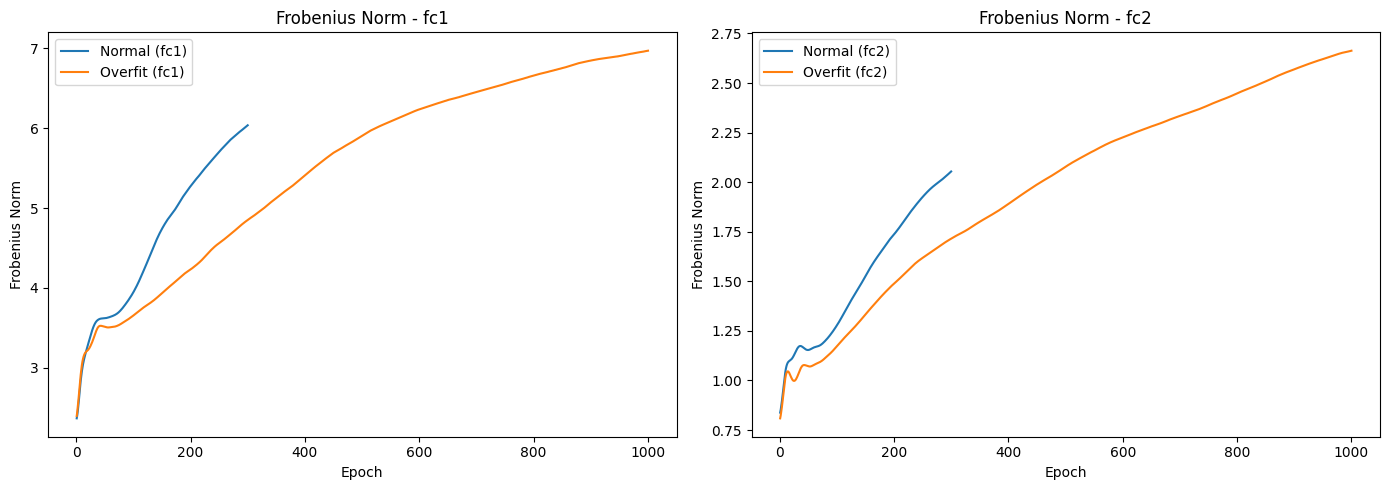

In [11]:
df = pd.read_excel('default of credit card clients.xls', header=1)
df = df.drop(columns='ID')
df.rename(columns={'default payment next month': 'default'}, inplace=True)

X = df.drop(columns='default').values
y = df['default'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=2):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == y).sum().item()
        total = y.size(0)
    model.train()
    return correct / total

def compute_layerwise_frobenius_norm(model):
    return {
        'fc1': torch.norm(model.fc1.weight.data, p='fro').item(),
        'fc2': torch.norm(model.fc2.weight.data, p='fro').item()
    }

def train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    train_accs = []
    test_accs = []
    layerwise_norms = {'fc1': [], 'fc2': []}

    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_accs.append(compute_accuracy(model, X_train, y_train))
        test_accs.append(compute_accuracy(model, X_test, y_test))

        norms = compute_layerwise_frobenius_norm(model)
        for layer in norms:
            layerwise_norms[layer].append(norms[layer])

    return model, losses, train_accs, test_accs, layerwise_norms

input_size = X_train.shape[1]

print("Training normal model (300 epochs)...")
model_normal = TwoLayerNN(input_size)
model_normal, normal_losses, normal_train_accs, normal_test_accs, normal_layer_norms = train_model(
    model_normal, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=300
)

print("Training overfit model (1000 epochs)...")
model_overfit = TwoLayerNN(input_size)
model_overfit, overfit_losses, overfit_train_accs, overfit_test_accs, overfit_layer_norms = train_model(
    model_overfit, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=1000
)

# Accuracy Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 301), normal_train_accs, label='Train Accuracy (Normal)')
plt.plot(range(1, 301), normal_test_accs, label='Test Accuracy (Normal)')
plt.title('Normal Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 1001), overfit_train_accs, label='Train Accuracy (Overfit)')
plt.plot(range(1, 1001), overfit_test_accs, label='Test Accuracy (Overfit)')
plt.title('Overfit Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Frobenius Norm Plots per layer
plt.figure(figsize=(14, 5))
for i, layer in enumerate(['fc1', 'fc2']):
    plt.subplot(1, 2, i+1)
    plt.plot(range(1, 301), normal_layer_norms[layer], label=f'Normal ({layer})')
    plt.plot(range(1, 1001), overfit_layer_norms[layer], label=f'Overfit ({layer})')
    plt.title(f'Frobenius Norm - {layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Frobenius Norm')
    plt.legend()

plt.tight_layout()
plt.show()


🔵 Training model for 300 epochs...

🔴 Training model for 1000 epochs...


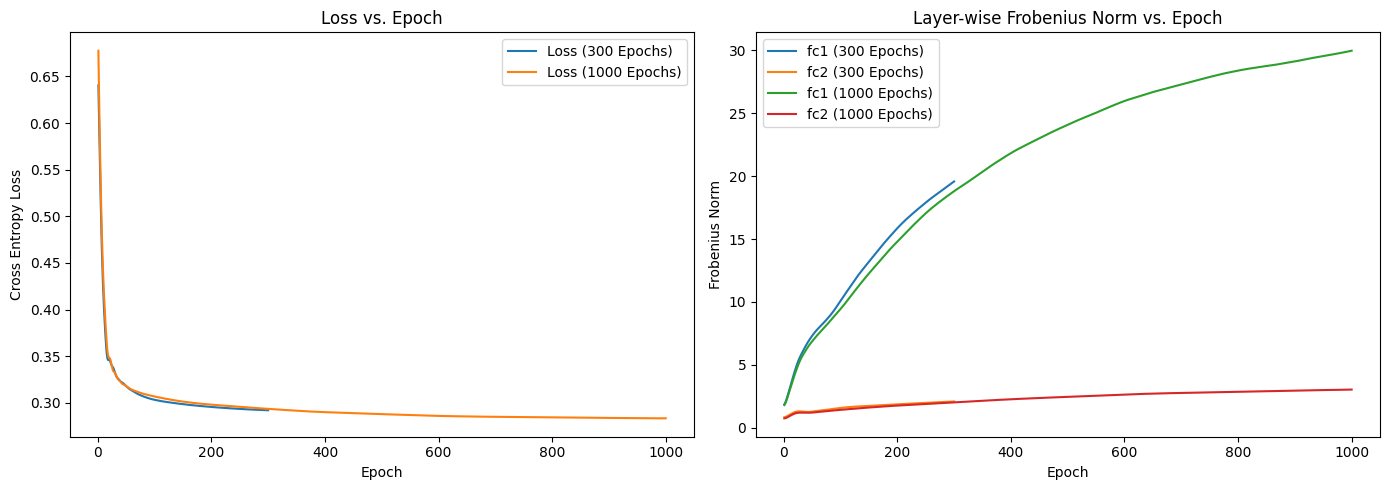

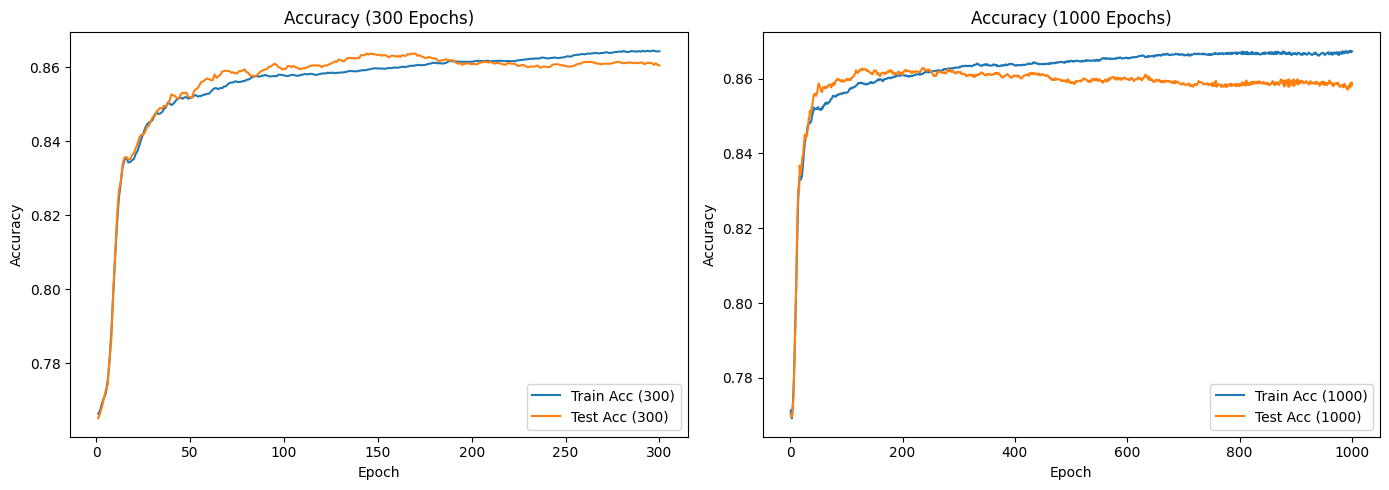

In [12]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load and clean data
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                 names=column_names, na_values=" ?", skipinitialspace=True)
df.dropna(inplace=True)

# Features and labels
X = df.drop("income", axis=1)
y = (df["income"] == ">50K").astype(int)

# Preprocessing
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train_np.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.long)

# Model definition
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size=10, output_size=2):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# Accuracy computation
def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == y).float().mean().item()
    model.train()
    return acc

# Layer-wise Frobenius norm
def compute_layerwise_frobenius_norm(model):
    return {
        'fc1': torch.norm(model.fc1.weight.data, p='fro').item(),
        'fc2': torch.norm(model.fc2.weight.data, p='fro').item()
    }

# Training
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    train_accs = []
    test_accs = []
    layerwise_norms = {'fc1': [], 'fc2': []}
    
    for epoch in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        train_accs.append(compute_accuracy(model, X_train, y_train))
        test_accs.append(compute_accuracy(model, X_test, y_test))
        
        norms = compute_layerwise_frobenius_norm(model)
        for layer in norms:
            layerwise_norms[layer].append(norms[layer])
    
    return model, losses, train_accs, test_accs, layerwise_norms

# Run training
input_size = X_train_tensor.shape[1]
torch.manual_seed(42)

print("🔵 Training model for 300 epochs...")
model_300 = TwoLayerNN(input_size)
model_300, losses_300, train_accs_300, test_accs_300, norms_300 = train_model(
    model_300, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=300
)

print("\n🔴 Training model for 1000 epochs...")
model_1000 = TwoLayerNN(input_size)
model_1000, losses_1000, train_accs_1000, test_accs_1000, norms_1000 = train_model(
    model_1000, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=1000
)

# Plot Loss and Frobenius Norms
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 301), losses_300, label="Loss (300 Epochs)")
plt.plot(range(1, 1001), losses_1000, label="Loss (1000 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 301), norms_300['fc1'], label="fc1 (300 Epochs)")
plt.plot(range(1, 301), norms_300['fc2'], label="fc2 (300 Epochs)")
plt.plot(range(1, 1001), norms_1000['fc1'], label="fc1 (1000 Epochs)")
plt.plot(range(1, 1001), norms_1000['fc2'], label="fc2 (1000 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Frobenius Norm")
plt.title("Layer-wise Frobenius Norm vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 301), train_accs_300, label="Train Acc (300)")
plt.plot(range(1, 301), test_accs_300, label="Test Acc (300)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (300 Epochs)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 1001), train_accs_1000, label="Train Acc (1000)")
plt.plot(range(1, 1001), test_accs_1000, label="Test Acc (1000)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (1000 Epochs)")
plt.legend()

plt.tight_layout()
plt.show()
